### Trabajo Práctico N° 3 ###
Visión por Computadora

Integrantes:
- Jose David Canal (a1523)
- Javier Gonzalo Etcheto (a1901)
- Marcelo Alejandro Le Mehaute (a1903)

Docente:
- Ing. Maxim Dorogov

### Objetivo ### 
Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template en Material_TPs/TP3/template.

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos.
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1.
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

## Template Matching en varias imágenes

Se implementa un sistema para detectar un patrón (template) en distintas imágenes, aunque aparezca en diferentes tamaños. Para eso:

- Se genera una pirámide de imágenes (`cv2.pyrDown`) para buscar el template en distintas resoluciones.
- Se aplica Canny (`cv2.Canny`) para detectar bordes, tanto en el template como en cada nivel de la imagen.
- Se usa `cv2.matchTemplate` con el método `TM_CCORR_NORMED` para comparar y encontrar coincidencias.
- Si el score es mayor a un mínimo (acá 0.2), se considera una detección válida.
- Se reescala la posición del match al tamaño original de la imagen.
- Se dibuja la detección con un rectángulo y el score.

In [4]:
def analyze_images(function, template_url, images, image_url_func, **kwargs):
    for image in images:
        function(template_url, image_url_func(image), **kwargs)

def image_url(leaf):
    return os.path.join('images', leaf)

def pyramid_construct(image, levels=3):
    pyramid = [(image, 0)]
    actual = image
    for level in range(1, levels + 1):
        actual = cv2.pyrDown(actual)
        pyramid.append((actual, level))
    return pyramid

In [5]:
def detect_templates_across_scales(template_gray, image_gray, scales, match_method, canny_th1, canny_th2, min_score):
    all_detections = []
    image_pyramid = pyramid_construct(image_gray)

    for level_img, level in image_pyramid:
        edges_img = cv2.Canny(level_img, canny_th1, canny_th2)

        for scale in scales:
            new_width = int(template_gray.shape[1] * scale)
            new_height = int(template_gray.shape[0] * scale)

            if new_width < 10 or new_height < 10:
                continue

            resized_template = cv2.resize(template_gray, (new_width, new_height))
            edges_template = cv2.Canny(resized_template, canny_th1, canny_th2)

            if edges_template.shape[0] > edges_img.shape[0] or edges_template.shape[1] > edges_img.shape[1]:
                continue

            match_result = cv2.matchTemplate(edges_img, edges_template, match_method)
            match_indices = np.where(match_result >= min_score)

            h, w = edges_template.shape
            for y, x in zip(*match_indices):
                all_detections.append({
                    "top_left": (x, y),
                    "size": (w, h),
                    "level": level,
                    "score": match_result[y, x]
                })

    return all_detections


In [6]:
def upscale_coordinates(top_left, size, pyramid_level):
    scale_factor = 2 ** pyramid_level
    x, y = top_left
    w, h = size
    x1 = x * scale_factor
    y1 = y * scale_factor
    x2 = (x + w) * scale_factor
    y2 = (y + h) * scale_factor
    return (x1, y1, x2, y2)

def visualize_detection(image_rgb, bounding_box, match_score):
    x1, y1, x2, y2 = map(int, bounding_box)
    
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
    cv2.putText(
        image_rgb,
        f"{match_score:.2f}",
        org=(x1, y1 - 10),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1.6,
        color=(0, 255, 0),
        thickness=4
    )

    plt.imshow(cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB))
    plt.title(f"Match Score: {match_score:.2f}")
    plt.axis("off")
    plt.show()


In [7]:
def find_best_template_match(template_path, image_path, match_method, canny_th1, canny_th2, min_score):
    scales = np.linspace(0.25, 1.0, 20)

    template_gray = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    image_bgr = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    detections = detect_templates_across_scales(
        template_gray, image_gray, scales, match_method, canny_th1, canny_th2, min_score
    )

    best_match = max(detections, key=lambda d: d["score"])
    bounding_box = upscale_coordinates(best_match["top_left"], best_match["size"], best_match["level"])

    visualize_detection(image_bgr, bounding_box, best_match["score"])

    return bounding_box, best_match["score"]


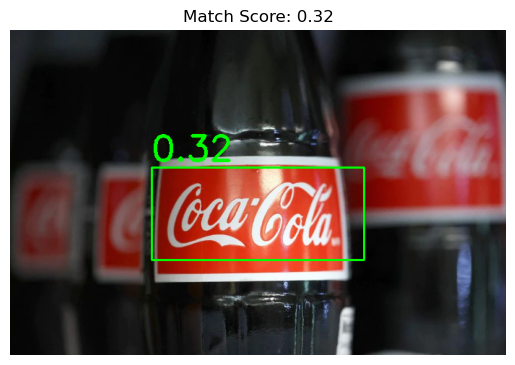

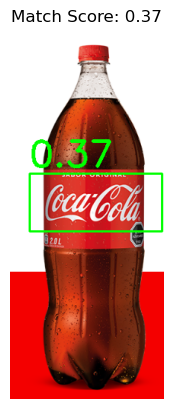

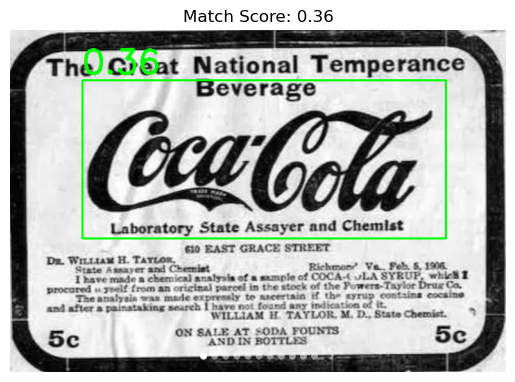

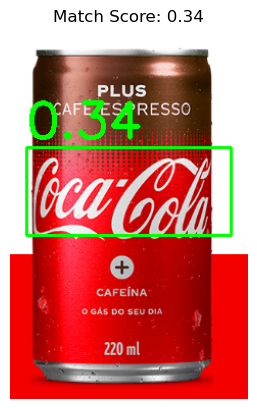

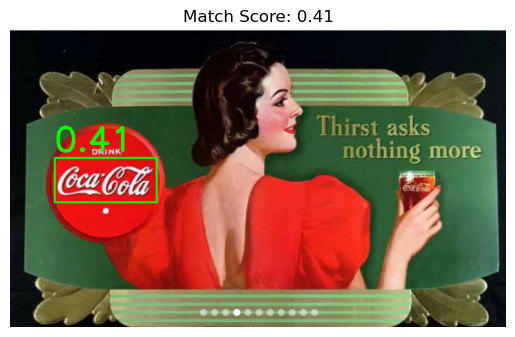

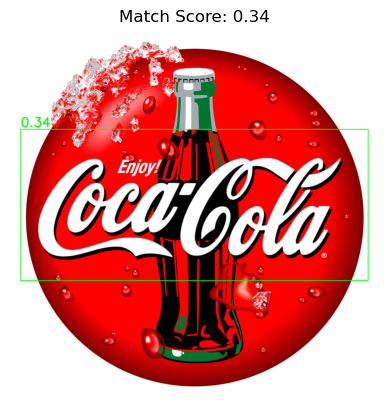

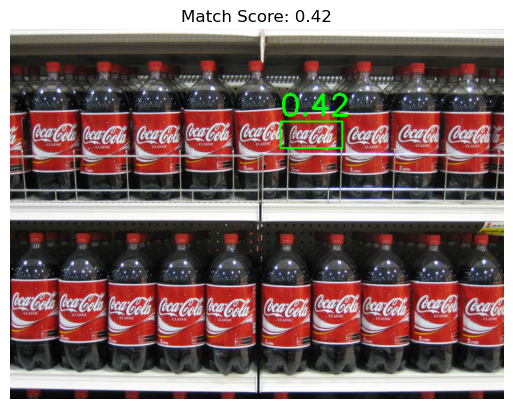

In [8]:
template_url = r'template\pattern.png'

# Lista de imágenes
images = [
    "logo_1.png", "coca_logo_1.png", "coca_retro_1.png",
    "coca_logo_2.png", "coca_retro_2.png",
    "COCA-COLA-LOGO.jpg", "coca_multi.png"
]

analyze_images(
    find_best_template_match,
    template_url,
    images,
    image_url,
    match_method=cv2.TM_CCORR_NORMED,
    canny_th1=50,
    canny_th2=500,
    min_score=0.2
)

Se mejora el algoritmo anterior para detectar **múltiples apariciones** del logo en una misma imagen, como pide el ítem 2 del enunciado.

- Se reutiliza la búsqueda en pirámide y Canny + `cv2.matchTemplate`, ahora guardando **todas las coincidencias** que superen cierto umbral de score.
- Para evitar falsos positivos cercanos entre sí, se filtran matches con `suppress_nearby_detections` usando una distancia mínima.
- Se visualiza cada detección con su bounding box y el score encima, sumando texto con borde para que se vea mejor.
- La función `find_all_template_matches` generaliza todo esto para aplicarlo en cualquier imagen.

Se prueba con la imagen `coca_multi.png`, que tiene muchas copias del logo. De las 19 instancias del logo, detecta 17, fallando solo en las 2 de los extremos de la fila inferior.

El algoritmo funciona muy bien en esta imagen en particular.

In [9]:
def suppress_nearby_detections(detections, min_distance=20):
    filtered = []

    sorted_detections = sorted(detections, key=lambda d: -d["score"])

    for current in sorted_detections:
        x1, y1 = current["top_left"]
        w1, h1 = current["size"]
        center1 = (x1 + w1 // 2, y1 + h1 // 2)
        level1 = current["level"]

        too_close = False
        for kept in filtered:
            x2, y2 = kept["top_left"]
            w2, h2 = kept["size"]
            center2 = (x2 + w2 // 2, y2 + h2 // 2)
            level2 = kept["level"]

            if level1 == level2:
                distance = np.hypot(center1[0] - center2[0], center1[1] - center2[1])
                if distance < min_distance:
                    too_close = True
                    break

        if not too_close:
            filtered.append(current)

    return filtered

In [10]:
def visualize_multiple_detections(image_bgr, detections):
    for det in detections:
        x1, y1, x2, y2 = upscale_coordinates(det["top_left"], det["size"], det["level"])
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

        cv2.rectangle(image_bgr, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
        # Borde negro para que el texto se lea sobre cualquier fondo
        cv2.putText(image_bgr, f"{det['score']:.2f}", (x1, y1 - 10),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0, 0, 0), thickness=3)
        cv2.putText(image_bgr, f"{det['score']:.2f}", (x1, y1 - 10),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0, 255, 0), thickness=2)

    if detections:
        min_score = min(d["score"] for d in detections)
        plt.title(f"Min Match Score: {min_score:.2f}")
    else:
        plt.title("No Detections Found")

    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [11]:
def find_all_template_matches(template_path, image_path, match_method, canny_th1, canny_th2, min_score):
    
    scales = np.linspace(0.25, 1.0, 20)

    template_gray = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    image_bgr = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    detections = detect_templates_across_scales(
        template_gray, image_gray, scales, match_method, canny_th1, canny_th2, min_score
    )

    unique_detections = suppress_nearby_detections(detections)
    visualize_multiple_detections(image_bgr, unique_detections)

    return unique_detections

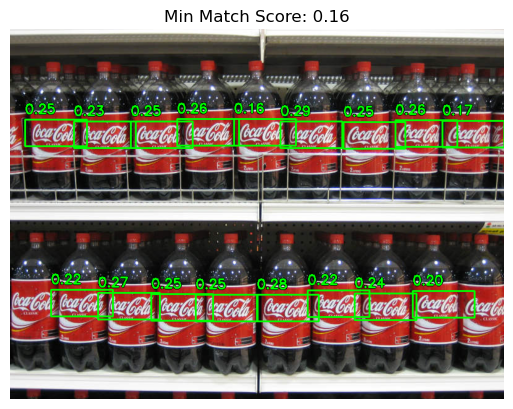

In [12]:
analyze_images(
    find_all_template_matches,
    template_url,
    ["coca_multi.png"],
    image_url,
    match_method=cv2.TM_CCOEFF_NORMED,
    canny_th1=200,
    canny_th2=500,
    min_score=0.16
)

### Generalización del algoritmo ###

Se agrega una etapa más para mejorar la calidad de las detecciones, sobre todo para eliminar falsos positivos o matches dudosos.

- Se calcula la cantidad de bordes del template con Canny.
- Para cada patch detectado, se valida que tenga una cantidad similar de bordes (`min_edge_ratio`) usando `validate_patch_edges`.
- Además, se filtra por score relativo al mejor match usando un `min_similarity`.
- Se sigue usando supresión de detecciones cercanas y visualización con bounding boxes y scores.

Este algoritmo se corre sobre todas las imágenes, incluyendo `coca_multi.png`.

En general **funciona bien en todas**. En la imagen con múltiples logos falla en las mismas dos de antes (los extremos de abajo) y también se le escapa la del medio de la fila de arriba. Pero igual, considerando la dificultad, el método da buenos resultados.


In [13]:
def validate_patch_edges(patch_gray, template_edges, canny_th1, canny_th2, min_edge_ratio):
    patch_edges = cv2.Canny(patch_gray, canny_th1, canny_th2)
    edge_count = np.sum(patch_edges > 0)
    return edge_count >= min_edge_ratio * template_edges

In [ ]:
def find_relevant_template_matches(template_path, image_path, match_method, 
                                   canny_th1, canny_th2, min_score, 
                                   min_similarity, min_edge_ratio):
    
    scales = np.linspace(0.25, 1.0, 20)

    template_gray = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    image_bgr = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    template_edges = cv2.Canny(template_gray, canny_th1, canny_th2)
    template_edge_count = np.sum(template_edges > 0)

    detections = detect_templates_across_scales(template_gray, image_gray, scales, 
                                                match_method, canny_th1, canny_th2, min_score)
    if not detections:
        return []

    best = max(detections, key=lambda d: d["score"])
    best_score = best["score"]
    relative_threshold = best_score * min_similarity

    filtered_detections = suppress_nearby_detections(detections)

    final_detections = []
    for det in filtered_detections:
        if det["score"] >= relative_threshold or det == best:
            x1, y1, x2, y2 = map(int, upscale_coordinates(det["top_left"], det["size"], det["level"]))
            patch = image_gray[y1:y2, x1:x2]
            if patch.shape[0] > 0 and patch.shape[1] > 0:
                if validate_patch_edges(patch, template_edge_count, canny_th1=canny_th1, 
                                        canny_th2=canny_th2, min_edge_ratio=min_edge_ratio):
                    final_detections.append(det)

    visualize_multiple_detections(image_bgr, final_detections)

    return final_detections


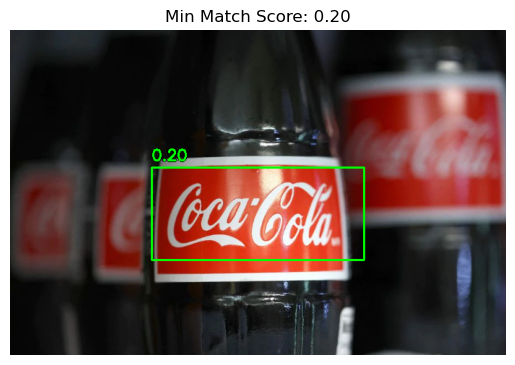

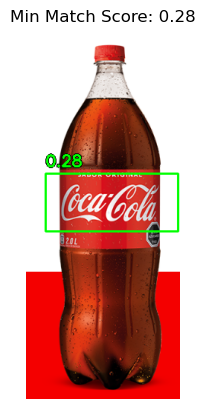

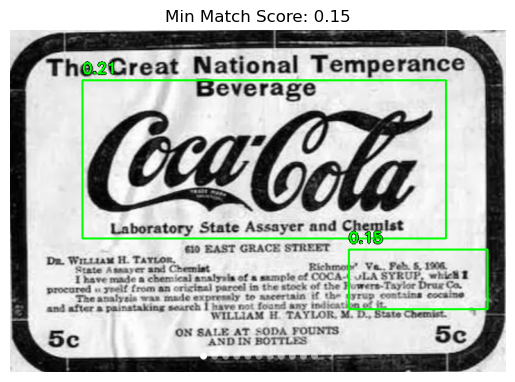

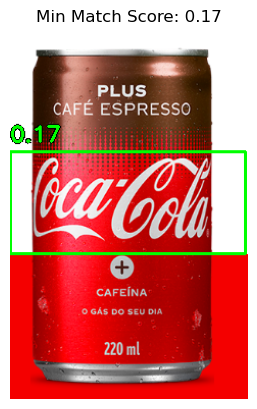

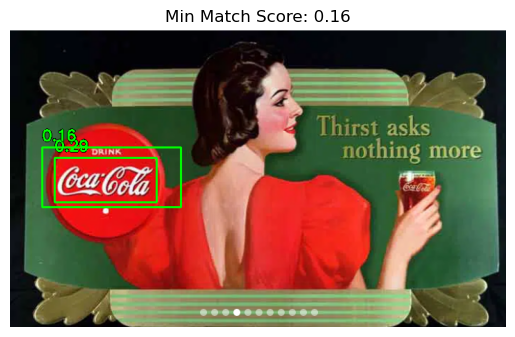

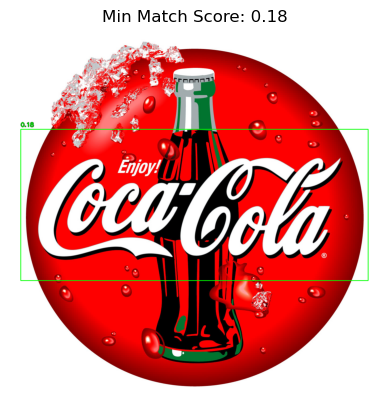

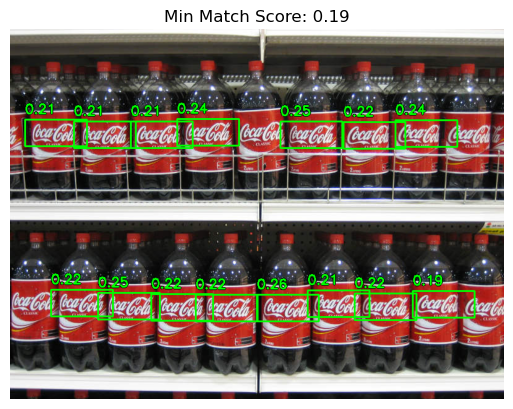

In [ ]:
analyze_images(
    find_relevant_template_matches,
    template_url,
    images,
    image_url,
    match_method=cv2.TM_CCOEFF_NORMED,
    canny_th1=100,
    canny_th2=150,
    min_score=0.15,
    min_similarity=0.5,
    min_edge_ratio=0.2
)